In [32]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 6 2021

@authors: R. van Hoof & A. Lozano
"""

# %matplotlib inline

'\nCreated on Wed May 6 2021\n\n@authors: R. van Hoof & A. Lozano\n'

In [33]:
import time
import os.path
import pickle # needed to store the results
from copy import deepcopy
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score as MI
from skopt.utils import use_named_args
from skopt.space import Integer, Categorical, Real
from skopt.utils import cook_initial_point_generator
from skopt import gp_minimize

########################
### Custom functions ###
########################

import importlib, electphos
importlib.reload(electphos)

from ninimplant import pol2cart, get_xyz # matrix rotation/translation ect
from lossfunc import DC, KL, get_yield, hellinger_distance
from electphos import create_grid, reposition_grid, implant_grid, get_phosphenes, prf_to_phos, gen_dummy_phos, get_cortical_magnification, cortical_spread, create_grid_v2
import visualsectors as gvs

# ignore "True-divide" warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [34]:
##########
## INIT ##
##########

# datafolder = '/path/to/data/'
# outputfolder = '/path/to/data/'
# datafolder = 'F:/Rick/Surfdrive_BACKUP/Data/NESTOR/HCP/subjects/'
# datafolder = r'C:/Users/Lozano/Desktop/NIN/bayesian_optimization_paper/data/subjects/'
# outputfolder =  r'C:/Users/Lozano/Desktop/NIN/bayesian_optimization_paper/data/output/'
datafolder = "C:/Users/user/YongtaeC/vimplant0812/data/demo/"
outputfolder = "C:/Users/user/YongtaeC/vimplant0812/data/output/"

# determine range of parameters used in optimization
dim1 = Integer(name='alpha', low=-90, high=90) # visual degrees 
dim2 = Integer(name='beta', low=-15, high=110) # visual degrees - -15 is probably lowest possible angle, otherwise other hem is in the way if hem = RH -> low = -110, high = 15
dim3 = Integer(name='offset_from_base', low=0, high=40) # in mm
dim4 = Integer(name='shank_length', low=10, high=40) # mm
dimensions = [dim1, dim2, dim3, dim4]

num_calls = 150
x0 = (0,0,20,25) # initial values for the four dimensions
num_initial_points = 10
dc_percentile = 50
n_contactpoints_shank = 10
spacing_along_xy = 1
WINDOWSIZE = 1000

# lists of loss term combinations to loop through
    # Dice Coefficient (1, 0, 0)
    # Yield (0, 1, 0)
    # Hellinger Distance (0, 0, 1)
loss_comb = ([(1, 0.1, 1)]) # weights for loss terms
loss_names = (['dice-yield-HD']) # substring in output filename

# lists of target maps to loop through
targ_comb = ([gvs.upper_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False), 
              gvs.lower_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False),
              gvs.inner_ring(windowsize=WINDOWSIZE, fwhm=400, radiusLow=0, radiusHigh=250, plotting=False),
              gvs.complete_gauss(windowsize=1000, fwhm=1200, radiusLow=0, radiusHigh=500, center=None, plotting=False)])
targ_names = (['targ-upper', 'targ-lower', 'targ-inner', 'targ-full'])

# constants pRF model
cort_mag_model = 'wedge-dipole' # which cortex model to use for the cortical magnification
view_angle = 90 #in degrees of visual angle
amp = 100 #stimulation amplitude in micro-amp (higher stimulation -> more tissue activated)

# INIT Bayes
amax = 1
bmax = 1
cmax = 1000
N=5
delta=0.2
thresh=0.05

# subjects to include
subj_list = [118225, 144226, 162935, 176542, 187345, 200614, 251833, 389357, 547046, 671855, 789373, 901139,  
100610, 125525, 145834, 164131, 177140, 191033, 201515, 257845, 393247, 550439, 680957, 814649, 901442, 
102311, 126426, 146129, 164636, 177645, 191336, 203418, 263436, 395756, 552241, 690152, 818859, 905147, 
102816, 128935, 146432, 165436, 177746, 191841, 204521, 283543, 397760, 562345, 706040, 825048, 910241, 
104416, 130114, 146735, 167036, 178142, 192439, 205220, 318637, 401422, 572045, 724446, 826353, 926862, 
105923, 130518, 146937, 167440, 178243, 192641, 209228, 320826, 406836, 573249, 725751, 833249, 927359, 
108323, 131217, 148133, 169040, 178647, 193845, 212419, 330324, 412528, 581450, 732243, 859671, 942658, 
109123, 131722, 150423, 169343, 180533, 195041, 214019, 346137, 429040, 585256, 751550, 861456, 943862, 
111312, 132118, 155938, 169444, 181232, 196144, 214524, 352738, 436845, 601127, 757764, 871762, 951457, 
111514, 134627, 156334, 169747, 181636, 197348, 221319, 360030, 463040, 617748, 765864, 872764, 958976, 
114823, 134829, 157336, 171633, 182436, 198653, 233326, 365343, 467351, 627549, 770352, 878776, 966975, 
115017, 135124, 158035, 172130, 182739, 199655, 239136, 380036, 525541, 638049, 771354, 878877, 971160, 
115825, 137128, 158136, 173334, 185442, 200210, 246133, 381038, 536647, 644246, 782561, 898176, 973770, 
116726, 140117, 159239, 175237, 186949, 200311, 249947, 385046, 541943, 654552, 783462, 899885, 995174, 'fsaverage']

subj_list = [100206]
subj_list = [100610]

# 원하는 그리드 크기/간격(예시: 7x7x5)
grid_nx = 10
grid_ny = 10
grid_nz = 10

# x,y 간격(mm). 예전처럼 하나만 쓰고 싶으면 둘 다 같은 값으로.
spacing_x = 1.0
spacing_y = 1.0

# 기존 파라미터는 그대로 사용 가능
shank_length = 25  # (최적화 변수인 경우 그대로 두고, 아니면 고정값)
n_contactpoints_shank = grid_nz      # 하위호환용으로 유지하고 싶으면 맞춰두기(선택)
spacing_along_xy = spacing_x         # 기존 변수 쓰는 곳 있으면 맞춰두기


In [35]:
################################################
## Functions related to Bayesian optimization ##
################################################

def custom_stopper(res, N=5, delta=0.2, thresh=0.05):
    '''
    Returns True (stops the optimization) when 
    the difference between best and worst of the best N are below delta AND the best is below thresh
    
    N = last number of cost values to track
    delta = ratio best and worst
    
    '''
    
    if len(res.func_vals) >= N:
        func_vals = np.sort(res.func_vals)
        worst = func_vals[N - 1]
        best = func_vals[0]
        
        return (abs((best - worst)/worst) < delta) & (best < thresh)
    else:
        return None

@use_named_args(dimensions=dimensions)
def f(alpha, beta, offset_from_base, shank_length):
    """
    This function encapsulates the electrode placement procedure and returns the cost value by 
    comparing the resulting phosphene map with the target map.    
    * First it creats a grid based on the four parameters. 
    * Phosphenes are generated based on the grid's contact points, 
      and their sizes are determined using cortical magnification and spread values. 
    * These phosphenes are converted into a 2D image representation. 
      The function then computes the dice coefficient and yield, and calculates the Hellinger 
      distance between the generated image and a target density. 
    * The resulting cost is a combination of these factors, 
      with penalties applied if the grid is invalid. 
    * The function also handles cases of invalid values and prints diagnostic information. 
    * Ultimately, the function returns the calculated cost used by the bayesopt algorithm.
    """
    
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)    
    
    # create grid
    orig_grid = create_grid_v2(
        start_location,
        shank_length=shank_length,
        n_x=grid_nx, n_y=grid_ny, n_z=grid_nz,
        spacing_x=spacing_x, spacing_y=spacing_y,
        offset_from_origin=0
    )

    
    # implanting grid
    _, contacts_xyz_moved, _, _, _, _, _, _, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)

    # get angle, ecc and rfsize for contactpoints (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)    
    phosphenes = get_phosphenes(contacts_xyz_moved, good_coords, polar_map, ecc_map, sigma_map)
    phosphenes_V1 = get_phosphenes(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    phosphenes_V2 = get_phosphenes(contacts_xyz_moved, good_coords_V2, polar_map, ecc_map, sigma_map)   
    phosphenes_V3 = get_phosphenes(contacts_xyz_moved, good_coords_V3, polar_map, ecc_map, sigma_map)
    
    #the inverse cortical magnification in degrees (visual angle)/mm tissue
    M = 1 / get_cortical_magnification(phosphenes_V1[:,1], cort_mag_model) 
    spread = cortical_spread(amp) #radius of current spread in the tissue, in mm
    sizes = spread*M #radius of current spread * cortical magnification = rf radius in degrees
    sigmas = sizes / 2  # radius to sigma of gaussian
    
    # phosphene size based on CMF + stim amp
    phosphenes_V1[:,2] = sigmas

    # generate map using Gaussians
    # transforming obtained phosphenes to a 2d image    
    phospheneMap = np.zeros((WINDOWSIZE,WINDOWSIZE), 'float32') 
    phospheneMap = prf_to_phos(phospheneMap, phosphenes_V1, view_angle=view_angle, phSizeScale=1)    
    phospheneMap /= phospheneMap.max()
    phospheneMap /= phospheneMap.sum()

    # bin_thesh determines size target
    bin_thresh=np.percentile(target_density, dc_percentile)# np.min(target_density) 

    # compute dice coefficient -> should be 1 -> invert cost 
    dice, im1, im2 = DC(target_density, phospheneMap, bin_thresh)
    par1 = 1.0 - (a * dice)

    # compute yield -> should be 1 -> invert cost
    grid_yield = get_yield(contacts_xyz_moved, good_coords)
    par2 = 1.0 - (b * grid_yield)

    # compute hellinger distance -> should be small -> keep cost
    hell_d = hellinger_distance(phospheneMap.flatten(), target_density.flatten())    
    
    ## validations steps
    if np.isnan(phospheneMap).any() or np.sum(phospheneMap) == 0:
        par1 = 1
        print('map is nan or 0')
    
    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
        print('Hellington is nan or inf')
    else:
        par3 = c * hell_d
    
    # combine cost functions
    cost = par1 + par2 + par3

    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
    
    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3
    
    print('    ', "{:.2f}".format(cost), "{:.2f}".format(dice), "{:.2f}".format(grid_yield), "{:.2f}".format(par3), grid_valid)
    return cost

def f_manual(alpha, beta, offset_from_base, shank_length, good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density):
    '''
    Copy from f, to obtain phosphene map and contact points for the optimized parameters. Used to visualize results.

    also returns coords used ect.
    '''
    
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)
    
    # create grid
    orig_grid = create_grid_v2(
        start_location,
        shank_length=shank_length,
        n_x=grid_nx, n_y=grid_ny, n_z=grid_nz,
        spacing_x=spacing_x, spacing_y=spacing_y,
        offset_from_origin=0
    )

    # implanting grid
    ref_contacts_xyz, contacts_xyz_moved, refline, refline_moved, projection, ref_orig, ray_visualize, new_location, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)

    # get angle, ecc and rfsize for contactpoints in each ROI (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)
    phosphenes =    get_phosphenes(contacts_xyz_moved, good_coords, polar_map, ecc_map, sigma_map)
    phosphenes_V1 = get_phosphenes(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    phosphenes_V2 = get_phosphenes(contacts_xyz_moved, good_coords_V2, polar_map, ecc_map, sigma_map)
    phosphenes_V3 = get_phosphenes(contacts_xyz_moved, good_coords_V3, polar_map, ecc_map, sigma_map)
    
    #the inverse cortical magnification in degrees (visual angle)/mm tissue
    M = 1 / get_cortical_magnification(phosphenes_V1[:,1], cort_mag_model)
    spread = cortical_spread(amp) #radius of current spread in the tissue, in mm
    sizes = spread*M #radius of current spread * cortical magnification = rf radius in degrees
    sigmas = sizes / 2  # radius to sigma of gaussian
    
    # phosphene size based on CMF + stim amp
    phosphenes_V1[:,2] = sigmas

    # generate map using Gaussians
    # transforming obtained phosphenes to a 2d image
    phospheneMap = np.zeros((WINDOWSIZE,WINDOWSIZE), 'float32')
    phospheneMap = prf_to_phos(phospheneMap, phosphenes_V1, view_angle=view_angle, phSizeScale=1)
    phospheneMap /= phospheneMap.max()
    phospheneMap /= phospheneMap.sum()
    print(view_angle)
    
    # can we relate bin_thesh to an eccentricity value? -> taken care of by masking the targets -> CHANGE TO 0.99999
    bin_thresh=np.percentile(target_density, dc_percentile)# np.min(target_density) # bin_thesh determines size target

    # compute dice coefficient -> should be large -> invert cost 
    dice, im1, im2 = DC(target_density, phospheneMap, bin_thresh)
    par1 = 1.0 - (a * dice)

    # compute yield -> should be 1 -> invert cost
    grid_yield = get_yield(contacts_xyz_moved, good_coords)
    par2 = 1.0 - (b * grid_yield)  
    
    # very important to normalize target density to same range as phospheneMap!
    target_density /= target_density.max()
    target_density /= target_density.sum()        
    
    # compute Hellinger distance -> should be small -> keep cost
    hell_d = hellinger_distance(phospheneMap.flatten(), target_density.flatten())
    
    ## validations steps
    if np.isnan(phospheneMap).any() or np.sum(phospheneMap) == 0:
        par1 = 1
        print('map is nan or 0')
    
    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
        print('Hellington is nan or inf')
    else:
        par3 = c * hell_d
    
    # combine cost functions
    cost = par1 + par2 + par3

    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
    
    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3
    
    return grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap

number of subjects: 1
target:  targ-upper
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.71 0.15 0.60 0.92 True
     3.68 0.02 0.06 0.95 False
     3.70 0.00 0.47 1.00 False
     3.63 0.04 0.39 0.97 False
     2.96 0.00 0.39 1.00 True
     2.83 0.07 0.42 0.93 True
     2.81 0.08 0.52 0.94 True
     2.82 0.07 0.42 0.93 True
     3.74 0.00 0.05 1.00 False
     3.59 0.06 0.31 0.93 False
map is nan or 0
Hellington is nan or inf
     2.96 0.00 0.45 1.00 True
     2.66 0.18 0.52 0.89 True
     3.60 0.06 0.39 0.95 False
     2.62 0.20 0.61 0.88 True
     2.81 0.07 0.47 0.93 True
     2.75 0.11 0.42 0.90 True
     2.56 0.24 0.47 0.84 True
     2.80 0.07 0.29 0.90 True
     2.76 0.11 0.38 0.91 True
     3.57 0.05 0.47 0.92 False
     2.74 0.10 0.49 0.89 True
     2.51 0.27 0.53 0.84 True
     2.76 0.09 0.46 0.89 True
     2.54 0.25 0.62 0.85 True
     2.53 0.26 0.51 0.84 True
     2.84 0.06 0.39 0.94 True
     2.65 0.17 0.49 0.87 True
     2.50 0.32 0.48 0.87 True
     2.63 0.23 0.47 0.91 True
   

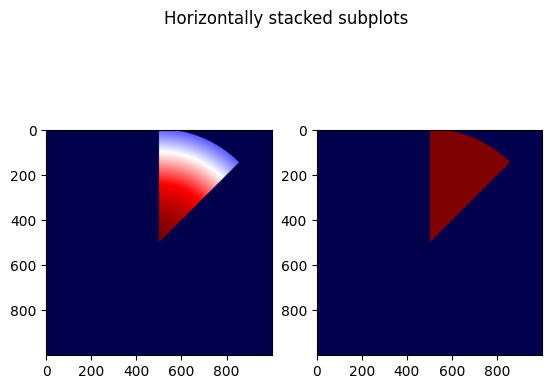

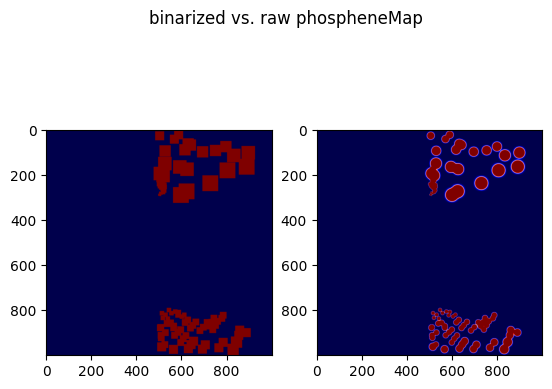

    max phospheneMap:  0.000150196
     2.83 0.09 0.57 0.97 True
     2.96 0.00 0.40 1.00 True
     2.88 0.05 0.47 0.97 True
     3.70 0.01 0.29 0.99 False
     2.96 0.00 0.42 1.00 True
     2.77 0.14 0.51 0.96 True
     3.60 0.07 0.26 0.94 False
     2.89 0.04 0.47 0.97 True
     3.66 0.03 0.34 0.98 False
     2.97 0.00 0.25 1.00 True
     2.91 0.03 0.42 0.98 True
     2.94 0.01 0.43 1.00 True
     2.96 0.00 0.42 1.00 True
     2.98 0.00 0.22 1.00 True
     2.97 0.00 0.31 1.00 True
     3.65 0.04 0.39 0.98 False
     3.72 0.00 0.29 1.00 False
     2.85 0.07 0.48 0.97 True
     2.97 0.00 0.35 1.00 True
     2.93 0.02 0.46 0.99 True
     2.93 0.02 0.41 0.99 True
     2.96 0.00 0.40 1.00 True
     2.95 0.01 0.44 1.00 True
     2.99 0.00 0.14 1.00 True
map is nan or 0
Hellington is nan or inf
     3.71 0.00 0.36 1.00 False
     2.89 0.04 0.47 0.97 True
     2.97 0.00 0.32 1.00 True
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.30 1.00 True
     2.96 0.00 0.36 1.00 True
     2.

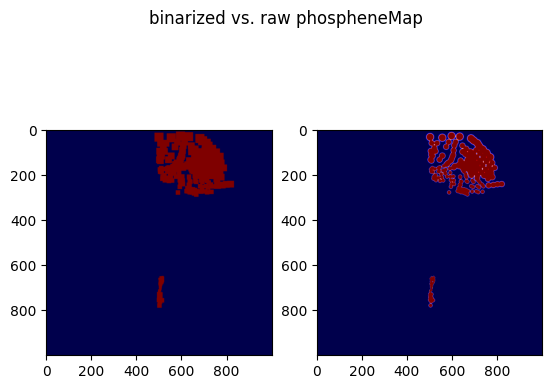

    max phospheneMap:  0.00020078731
target:  targ-lower
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.67 0.19 0.60 0.92 True
     3.52 0.12 0.41 0.93 False
     2.87 0.06 0.46 0.97 True
     3.65 0.03 0.38 0.98 False
     2.97 0.00 0.35 1.00 True
     3.72 0.00 0.34 1.00 False
     2.95 0.00 0.43 1.00 True
     3.65 0.04 0.41 0.98 False
     2.51 0.31 0.53 0.88 True
     3.65 0.04 0.17 0.96 False
     2.97 0.00 0.30 1.00 True
     3.70 0.00 0.51 1.00 False
     2.87 0.05 0.47 0.97 True
     2.84 0.06 0.71 0.97 True
     2.51 0.31 0.18 0.84 True
     3.73 0.00 0.25 1.00 False
     2.64 0.22 0.17 0.88 True
     3.68 0.00 0.55 0.99 False
     2.28 0.48 0.36 0.80 True
     2.62 0.25 0.12 0.88 True
     2.48 0.32 0.47 0.85 True
     2.96 0.00 0.38 1.00 True
     2.51 0.31 0.24 0.84 True
     2.17 0.55 0.40 0.76 True
     2.17 0.54 0.43 0.75 True
map is nan or 0
Hellington is nan or inf
     3.70 0.00 0.46 1.00 False
     2.18 0.53 0.46 0.76 True
     2.20 0.52 0.44 0.76 True
     2.17 0.53 0

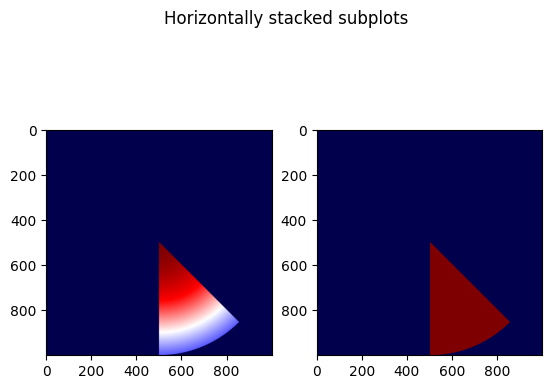

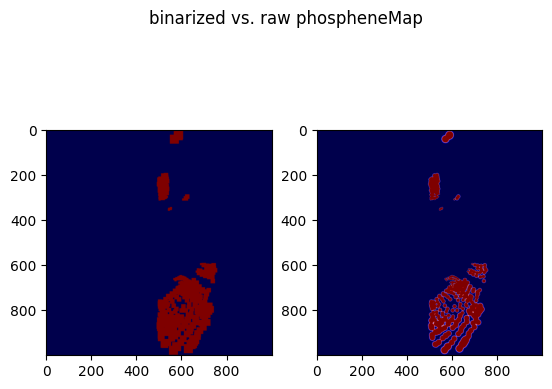

    max phospheneMap:  0.0001648238
     2.68 0.19 0.57 0.93 True
     3.65 0.03 0.40 0.98 False
     3.58 0.08 0.38 0.95 False
     2.90 0.04 0.40 0.98 True
     3.69 0.02 0.22 0.98 False
     2.59 0.25 0.42 0.88 True
     3.71 0.00 0.34 1.00 False
     2.83 0.07 0.32 0.94 True
     3.70 0.01 0.41 1.00 False
     2.80 0.10 0.53 0.95 True
     3.74 0.00 0.10 1.00 False
     3.70 0.00 0.29 0.98 False
     2.88 0.05 0.54 0.98 True
     2.92 0.03 0.38 0.98 True
     2.68 0.19 0.38 0.90 True
     2.63 0.22 0.41 0.89 True
     2.86 0.07 0.27 0.96 True
     2.86 0.06 0.47 0.97 True
     2.83 0.08 0.38 0.96 True
     2.87 0.06 0.39 0.97 True
     2.87 0.05 0.48 0.97 True
     3.73 0.00 0.21 1.00 False
     2.50 0.30 0.53 0.85 True
     2.77 0.12 0.50 0.93 True
     3.68 0.03 0.12 0.97 False
     3.47 0.16 0.41 0.93 False
     2.81 0.09 0.47 0.95 True
     2.46 0.33 0.53 0.84 True
     3.24 0.31 0.52 0.85 False
     2.92 0.03 0.41 0.99 True
     2.92 0.03 0.38 0.99 True
     2.47 0.35 0.38 0.8

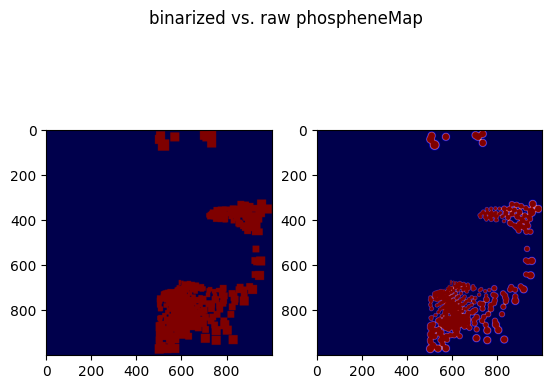

    max phospheneMap:  0.00011452627
target:  targ-inner
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.53 0.28 0.60 0.87 True
     2.64 0.17 0.43 0.85 True
     2.54 0.24 0.44 0.82 True
     2.57 0.22 0.41 0.83 True
     3.35 0.21 0.32 0.84 False
     2.95 0.02 0.07 0.98 True
     2.49 0.25 0.60 0.80 True
     3.69 0.01 0.11 0.96 False
map is nan or 0
Hellington is nan or inf
     3.70 0.00 0.45 1.00 False
     3.32 0.24 0.33 0.84 False
     2.58 0.21 0.41 0.83 True
     2.56 0.22 0.51 0.83 True
     2.56 0.20 0.62 0.83 True
     3.30 0.24 0.42 0.83 False
     2.47 0.28 0.52 0.80 True
     2.46 0.29 0.47 0.80 True
map is nan or 0
Hellington is nan or inf
     2.94 0.00 0.61 1.00 True
     2.61 0.19 0.45 0.85 True
     2.52 0.23 0.65 0.81 True
     2.41 0.33 0.56 0.79 True
     2.37 0.35 0.57 0.78 True
     2.38 0.34 0.56 0.78 True
     2.71 0.13 0.31 0.88 True
     2.56 0.22 0.38 0.82 True
     2.49 0.27 0.50 0.81 True
     2.59 0.20 0.44 0.84 True
     3.71 0.01 0.06 0.97 False
     2.3

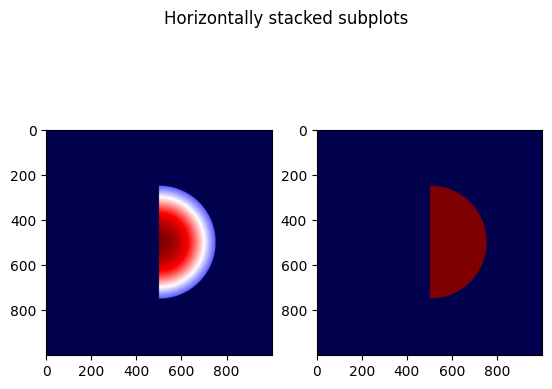

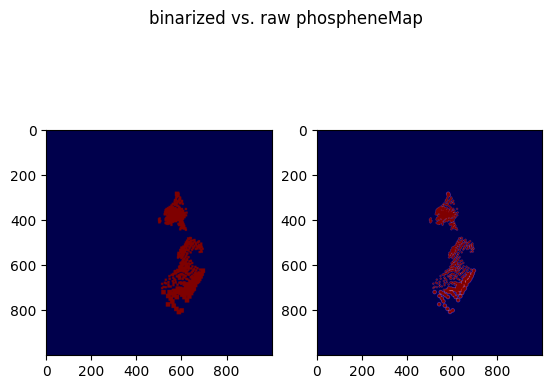

    max phospheneMap:  0.00037430244
     2.73 0.16 0.57 0.94 True
     2.95 0.02 0.30 0.99 True
     3.35 0.24 0.30 0.87 False
     3.32 0.25 0.38 0.86 False
     2.74 0.17 0.35 0.94 True
     2.59 0.25 0.41 0.88 True
map is nan or 0
Hellington is nan or inf
     3.70 0.00 0.52 1.00 False
     2.63 0.24 0.47 0.92 True
     2.57 0.27 0.40 0.88 True
     3.72 0.00 0.15 0.99 False
     2.43 0.36 0.45 0.84 True
     3.71 0.00 0.23 0.99 False
     3.66 0.04 0.35 0.98 False
     2.42 0.37 0.44 0.84 True
     2.39 0.38 0.46 0.83 True
     2.76 0.13 0.50 0.94 True
     2.44 0.36 0.43 0.85 True
     2.39 0.38 0.45 0.82 True
     2.44 0.35 0.47 0.83 True
     2.34 0.42 0.59 0.82 True
     2.28 0.46 0.66 0.80 True
     2.31 0.44 0.67 0.82 True
     2.49 0.33 0.47 0.86 True
     2.69 0.18 0.43 0.91 True
     2.29 0.45 0.66 0.81 True
     2.31 0.44 0.69 0.82 True
     2.32 0.44 0.49 0.81 True
     2.51 0.26 0.36 0.81 True
     3.17 0.37 0.47 0.84 False
     2.36 0.43 0.47 0.83 True
     2.27 0.47 

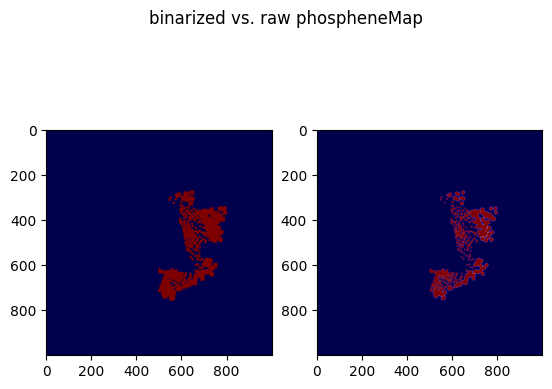

    max phospheneMap:  0.00034317444
target:  targ-full
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.70 0.13 0.60 0.90 True
     2.83 0.05 0.43 0.93 True
     3.66 0.03 0.20 0.95 False
     2.59 0.20 0.61 0.85 True
     3.59 0.05 0.35 0.93 False
     2.94 0.00 0.47 0.99 True
     2.89 0.02 0.49 0.96 True
     3.57 0.07 0.32 0.92 False
     2.68 0.15 0.55 0.88 True
     2.84 0.05 0.38 0.93 True
     3.58 0.04 0.54 0.93 False
     2.55 0.25 0.51 0.85 True
     2.44 0.32 0.55 0.82 True
     2.42 0.35 0.44 0.81 True
     3.68 0.02 0.11 0.96 False
map is nan or 0
Hellington is nan or inf
     2.98 0.00 0.24 1.00 True
     3.57 0.06 0.48 0.92 False
     2.72 0.12 0.47 0.89 True
     2.45 0.36 0.27 0.84 True
     2.25 0.48 0.42 0.78 True
     3.61 0.05 0.26 0.93 False
     3.66 0.01 0.54 0.97 False
     2.29 0.45 0.42 0.78 True
     2.40 0.35 0.61 0.81 True
     2.56 0.25 0.48 0.86 True
     2.82 0.07 0.30 0.92 True
map is nan or 0
Hellington is nan or inf
     3.70 0.00 0.53 1.00 False
     2

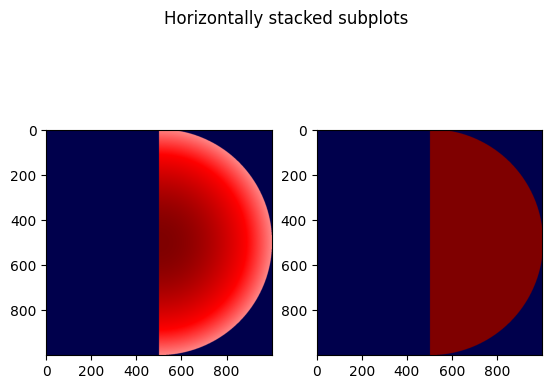

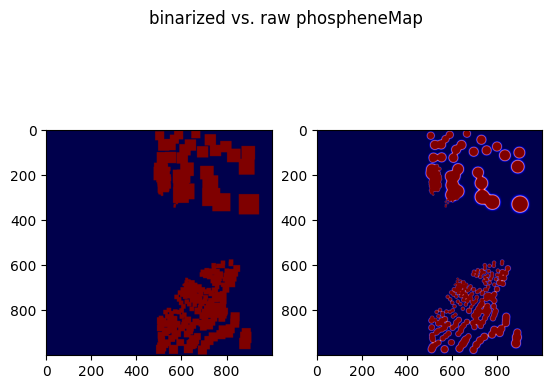

    max phospheneMap:  9.2553295e-05
     2.63 0.20 0.57 0.89 True
     3.46 0.14 0.34 0.89 False
     2.73 0.13 0.30 0.89 True
     2.73 0.12 0.48 0.90 True
     2.72 0.13 0.36 0.89 True
     3.67 0.02 0.12 0.95 False
     2.72 0.13 0.46 0.89 True
     2.83 0.07 0.18 0.92 True
     3.54 0.09 0.28 0.91 False
     2.64 0.19 0.41 0.87 True
     3.57 0.06 0.39 0.92 False
     2.67 0.17 0.37 0.88 True
     2.66 0.19 0.29 0.87 True
     2.82 0.07 0.41 0.93 True
     2.43 0.33 0.57 0.82 True
     2.57 0.23 0.47 0.85 True
     2.51 0.28 0.42 0.83 True
     2.47 0.30 0.53 0.82 True
     2.72 0.13 0.46 0.89 True
     2.95 0.00 0.48 0.99 True
     2.30 0.43 0.56 0.78 True
     2.39 0.36 0.55 0.81 True
     3.70 0.00 0.39 0.99 False
     2.32 0.42 0.54 0.79 True
     2.34 0.40 0.55 0.80 True
     2.80 0.09 0.19 0.91 True
     3.35 0.22 0.43 0.86 False
     2.55 0.26 0.40 0.84 True
map is nan or 0
Hellington is nan or inf
     3.74 0.00 0.06 1.00 False
     2.40 0.36 0.51 0.81 True
     2.40 0.35 

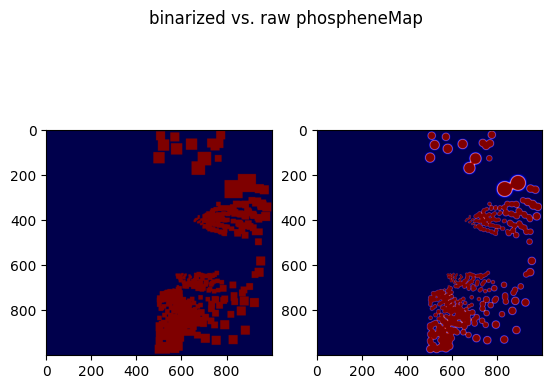

    max phospheneMap:  7.846276e-05


In [36]:
###################
## Main Sim Loop ##
###################

# set file names
fname_ang = 'inferred_angle.mgz'
fname_ecc = 'inferred_eccen.mgz'
fname_sigma = 'inferred_sigma.mgz'
fname_anat = 'T1.mgz'
fname_aparc = 'aparc+aseg.mgz'
fname_label = 'inferred_varea.mgz'
print('number of subjects: ' + str(len(subj_list)))

# set beta angle constraints according to hemisphere
dim2_lh = Integer(name='beta', low=-15, high=110)
dim2_rh = Integer(name='beta', low=-110, high=15)

# loop through phosphene target maps and combinations of loss terms
for target_density, ftarget in zip(targ_comb, targ_names):
    for (a, b, c), floss in zip(loss_comb, loss_names):
        # set target
        target_density /= target_density.max()
        target_density /= target_density.sum()
        # can we relate bin_thesh to an eccentricity value?
        bin_thresh=np.percentile(target_density, dc_percentile ) #np.min(target_density) # bin_thesh determines size target
        target_density_bin = (target_density > bin_thresh).astype(bool)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Horizontally stacked subplots')
        plt.subplot(1,2,1).imshow(target_density, cmap = 'seismic')
        plt.subplot(1,2,2).imshow(target_density_bin, cmap = 'seismic')

        for s in subj_list:
            # data_dir = datafolder + str(s)+ '/T1w/' + str(s) + '/mri/'            
            data_dir = datafolder

            if s == 'fsaverage':
                data_dir = datafolder + str(s) + '/mri/'
                
            # load maps
            ang_img = nib.load(data_dir+fname_ang)
            polar_map = ang_img.get_fdata()
            ecc_img = nib.load(data_dir+fname_ecc)
            ecc_map = ecc_img.get_fdata()
            sigma_img = nib.load(data_dir+fname_sigma)
            sigma_map = sigma_img.get_fdata()                
            aparc_img = nib.load(data_dir+fname_aparc)
            aparc_roi = aparc_img.get_fdata()
            label_img = nib.load(data_dir+fname_label)
            label_map = label_img.get_fdata()

            # compute valid voxels
            dot = (ecc_map * polar_map)
            good_coords = np.asarray(np.where(dot != 0.0))

            # filter gm per hemisphere
            cs_coords_rh = np.where(aparc_roi == 1021)
            cs_coords_lh = np.where(aparc_roi == 2021)
            gm_coords_rh = np.where((aparc_roi >= 1000) & (aparc_roi < 2000))
            gm_coords_lh = np.where(aparc_roi > 2000)
            xl,yl,zl = get_xyz(gm_coords_lh)
            xr,yr,zr = get_xyz(gm_coords_rh)
            GM_LH = np.array([xl,yl,zl]).T
            GM_RH = np.array([xr,yr,zr]).T

            # extract labels
            V1_coords_rh = np.asarray(np.where(label_map == 1))
            V1_coords_lh = np.asarray(np.where(label_map == 1))
            V2_coords_rh = np.asarray(np.where(label_map == 2))
            V2_coords_lh = np.asarray(np.where(label_map == 2))
            V3_coords_rh = np.asarray(np.where(label_map == 3))
            V3_coords_lh = np.asarray(np.where(label_map == 3))

            # divide V1 coords per hemisphere
            good_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(good_coords).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            good_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(good_coords).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V1_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V1_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V1_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V1_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V2_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V2_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V2_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V2_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V3_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V3_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V3_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V3_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T           

            # find center of left and right calcarine sulci
            median_lh = [np.median(cs_coords_lh[0][:]), np.median(cs_coords_lh[1][:]), np.median(cs_coords_lh[2][:])]
            median_rh = [np.median(cs_coords_rh[0][:]), np.median(cs_coords_rh[1][:]), np.median(cs_coords_rh[2][:])]

            # get GM mask and compute dorsal/posterior planes
            gm_mask = np.where(aparc_roi != 0)
            print('target: ', ftarget)
            print('loss: ', floss)
            print('a,b,c: ', a,b,c)

            # apply optimization to each hemisphere
            for gm_mask, hem, start_location, good_coords, good_coords_V1, good_coords_V2, good_coords_V3, dim2 in zip([GM_LH, GM_RH], ['LH', 'RH'], [median_lh, median_rh], [good_coords_lh, good_coords_rh], [V1_coords_lh, V1_coords_rh], [V2_coords_lh, V2_coords_rh], [V3_coords_lh, V3_coords_rh], [dim2_lh, dim2_rh]):        
                
                # check if already done
                n_total = grid_nx * grid_ny * grid_nz
                shape_tag = f"{grid_nx}x{grid_ny}x{grid_nz}"

                data_id = f"{s}_{hem}_V1_n{n_total}_{shape_tag}_{floss}_{thresh}_{ftarget}"
                fname = os.path.join(outputfolder, data_id + '.pkl')
                if os.path.exists(fname):
                    print(f"{s} {hem} {ftarget} {floss} already processed.")
                else:
                    dimensions = [dim1, dim2, dim3, dim4]

                    # create initial point generator
                    lhs2 = cook_initial_point_generator("lhs", criterion="maximin")

                    # optimize
                    res = gp_minimize(f, x0=x0, dimensions=dimensions, n_jobs=-1, n_calls=num_calls, n_initial_points=num_initial_points, initial_point_generator=lhs2, callback=[custom_stopper])

                    # print results
                    print('subject ', s, ' ', hem)
                    print('best alpha:', res.x[0])
                    print('best beta:',res.x[1])
                    print('best offset_from_base:', res.x[2])
                    print('best shank_length:',res.x[3])
                    grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap = f_manual(res.x[0], res.x[1],res.x[2], res.x[3], good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density)
                    print('best dice, yield, KL: ', dice, grid_yield, hell_d)

                    # show resulting binary phosphene map (reflects dice coefficient)
                    bin_thresh=np.percentile(phospheneMap, dc_percentile) #np.min(target_density) # bin_thesh determines size target
                    phospheneMap_bin = (phospheneMap > bin_thresh).astype(bool)
                    fig, (ax1, ax2) = plt.subplots(1, 2)
                    fig.suptitle('binarized vs. raw phospheneMap')
                    plt.subplot(1,2,1).imshow(phospheneMap_bin, cmap = 'seismic', vmin=0, vmax=np.max(phospheneMap)/100)
                    plt.subplot(1,2,2).imshow(phospheneMap, cmap = 'seismic', vmin=0, vmax=np.max(phospheneMap)/100)
                    plt.show()
                    print('    max phospheneMap: ', np.max(phospheneMap))        

                    # Saving the objects
                    with open(fname, 'wb') as file:
                        pickle.dump([res, 
                                     grid_valid, 
                                     dice, hell_d, 
                                     grid_yield, 
                                     contacts_xyz_moved,
                                     good_coords,
                                     good_coords_V1,
                                     good_coords_V2,
                                     good_coords_V3,
                                     phosphenes,
                                     phosphenes_V1,
                                     phosphenes_V2,
                                     phosphenes_V3], file, protocol=-1)

In [37]:
def compute_shank_ids(coords_xyz, tol=0.5):
    """
    coords_xyz: (N,3) 또는 (3,N) 둘 다 허용. (x,y) 좌표를 tol로 라운딩하여 shank를 군집화.
    return    : (N,) int array (채널별 shank ID)
    """
    arr = np.asarray(coords_xyz)
    if arr.ndim != 2:
        raise ValueError(f"coords_xyz must be 2D, got shape {arr.shape}")

    # (3, N) 인지 (N, 3) 인지 자동 판별
    if arr.shape[0] == 3 and arr.shape[1] != 3:
        # (3, N) 형태 → (N, 3)로 전치
        arr = arr.T
    elif arr.shape[1] == 3:
        # 이미 (N,3)
        pass
    else:
        raise ValueError(f"coords_xyz shape not understood: {arr.shape}")

    # (x,y)만 써서 "기둥" 군집화
    xy = np.round(arr[:, :2] / tol).astype(int)
    _, inv = np.unique(xy, axis=0, return_inverse=True)
    return inv


Loaded: 100610_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl
phosphenes_V1: (578, 3)
[warn] contacts vs V1 rows mismatch: contacts=1000, V1=578
Candidates: 553, DS feature: (10000, 553)
K_list: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

=== K = 1 ===
[G] Dice=0.0443 H=0.9421 L=-0.8979  time=0.06s

=== K = 2 ===
[G] Dice=0.0866 H=0.9176 L=-0.8310  time=0.12s

=== K = 3 ===
[G] Dice=0.1206 H=0.8986 L=-0.7780  time=0.16s

=== K = 4 ===
[G] Dice=0.1480 H=0.8869 L=-0.7390  time=0.21s

=== K = 5 ===
[G] Dice=0.1650 H=0.8703 L=-0.7052  time=0.26s

=== K = 6 ===
[G] Dice=0.1911 H=0.8606 L=-0.6694  time=0.31s

=== K = 7 ===
[G] Dice=0.2182 H=0.8479 L=

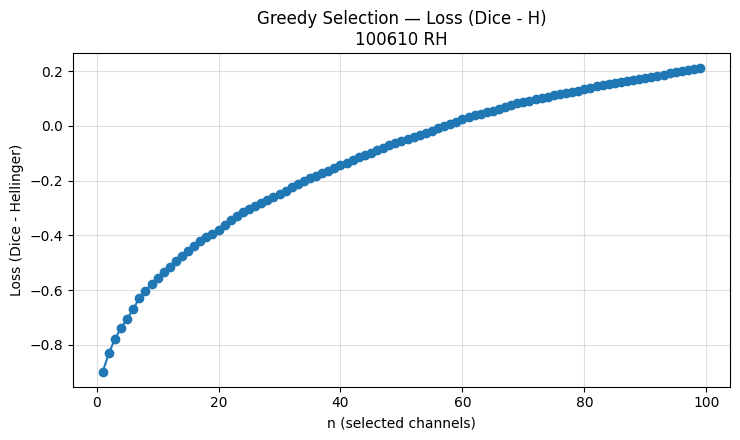

In [40]:
# -*- coding: utf-8 -*-
# Greedy selection only over K in {1,2,...,400}
# Objective / "Loss":  L = Dice - Hellinger
# - Selection runs in a downsampled (DS) space for speed; final evaluation is at full-res.
# - We maximize L during greedy selection (equivalently, "loss" here is an objective to be maximized).
#
# Input pickle (example):
#   C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl
#
# No saving of metrics or plots; the plot is displayed only.


import os, time, pickle
import numpy as np
import matplotlib.pyplot as plt

from electphos import prf_to_phos
from lossfunc import DC, hellinger_distance

# -----------------
# Config
# -----------------
PICKLE_PATH = r"C:\Users\user\YongtaeC\vimplant0812\data\output\100610\100610_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl"
WINDOWSIZE  = 1000
VIEW_ANGLE  = 90
DC_PERCENTILE = 50

# Downsample factor for selection space (1000 -> 100)
DS = 10  # average pooling

# Selection sizes: 1..400
K_LIST = list(range(1, 100))

EPS = 1e-12

# -----------------
# Helpers
# -----------------
def normalize_pdf(x, eps=EPS):
    x = np.clip(x, 0, None).astype(np.float32)
    s = float(x.sum())
    return x / (s + eps)

def downsample_avg(img, factor=DS):
    H, W = img.shape
    assert H % factor == 0 and W % factor == 0, "Image size must be divisible by factor"
    h, w = H // factor, W // factor
    return img.reshape(h, factor, w, factor).mean(axis=(1, 3))

def single_map_raw(phosphenes_block):
    pm = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
    if phosphenes_block.size == 0:
        return pm
    return prf_to_phos(pm, phosphenes_block, view_angle=VIEW_ANGLE, phSizeScale=1)

def dice_H_loss(target_pdf, cand_pdf, bin_thresh):
    """Return (dice, Hellinger, loss=dice-H)."""
    dice, _, _ = DC(target_pdf, cand_pdf, bin_thresh)
    H = float(hellinger_distance(cand_pdf.flatten(), target_pdf.flatten()))
    loss = float(dice) - H
    return float(dice), float(H), float(loss)

# -----------------
# Load pickle & build candidates (one-time)
# -----------------
with open(PICKLE_PATH, "rb") as f:
    (res, grid_valid, dice_best, hell_d_best, grid_yield_best,
     contacts_xyz_moved, good_coords, good_coords_V1, good_coords_V2, good_coords_V3,
     phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3) = pickle.load(f)

print("Loaded:", os.path.basename(PICKLE_PATH))
print("phosphenes_V1:", phosphenes_V1.shape)



# 후보 구축 + 공통 전처리
candidate_idx = []
ds_raw_cols = []   # (F_ds x n_ch) columns: DS raw per channel
target_pm_raw = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)

h_ds, w_ds = WINDOWSIZE//DS, WINDOWSIZE//DS
F_ds = h_ds * w_ds

for i in range(phosphenes_V1.shape[0]):
    pm_raw = single_map_raw(phosphenes_V1[i:i+1, :])
    if pm_raw.sum() <= 0:
        continue
    target_pm_raw += pm_raw

    v_ds_raw = downsample_avg(pm_raw, DS).reshape(-1).astype(np.float32)  # raw (not normalized)
    ds_raw_cols.append(v_ds_raw)
    candidate_idx.append(i)

candidate_idx = np.array(candidate_idx, dtype=int)
if candidate_idx.size == 0:
    raise RuntimeError("No valid V1-mapped candidates.")

# --- Shank 라벨링 (x,y 동일한 기둥을 같은 ID로) ---
shank_ids_all = compute_shank_ids(contacts_xyz_moved, tol=0.5)

# sanity check: 채널 개수와 일치하는지
n_contacts = shank_ids_all.shape[0]
if n_contacts != phosphenes_V1.shape[0]:
    print(f"[warn] contacts vs V1 rows mismatch: contacts={n_contacts}, V1={phosphenes_V1.shape[0]}")
    # 그래도 후보 인덱싱은 candidate_idx 기준으로 하므로 계속 진행 가능

shank_ids = shank_ids_all[candidate_idx]

n_shanks = np.unique(shank_ids).size

X_ds = np.stack(ds_raw_cols, axis=1)      # (F_ds x n_ch)  for Greedy
target_pdf = normalize_pdf(target_pm_raw)
target_ds_pdf = normalize_pdf(downsample_avg(target_pm_raw, DS).reshape(-1))
BIN_THRESH = np.percentile(target_pdf, DC_PERCENTILE)

n_ch = candidate_idx.size
print(f"Candidates: {n_ch}, DS feature: {X_ds.shape}")

# n 리스트 정리(유효 후보 수 이하만)
K_list = [k for k in K_LIST if k <= min(n_ch, n_shanks)]
print("K_list:", K_list)

# On-demand raw map provider (avoid caching all full-res maps)
_raw_cache = {}
def get_raw_map(ch):
    if ch not in _raw_cache:
        _raw_cache[ch] = single_map_raw(phosphenes_V1[ch:ch+1, :])
    return _raw_cache[ch]

# -----------------
# Metric arrays (Greedy only)
# -----------------
G_dice = []; G_H = []; G_loss = []; G_time = []

# -----------------
# Run Greedy per K  (maximize loss = Dice - H)
# -----------------
t2d = target_ds_pdf.reshape(h_ds, w_ds)   # reuse outside inner loop
bin_th_ds = np.percentile(t2d, DC_PERCENTILE)

for K in K_list:
    print(f"\n=== K = {K} ===")

    t0 = time.time()
    remaining = set(range(n_ch))
    selected_local = []
    current_ds_raw = np.zeros((F_ds,), dtype=np.float32)
    used_shanks = set()  # <<< 추가: 이미 선택된 shank 집합

    for step in range(1, K+1):
        best_score = -1e9
        best_i = None

        # 후보가 남았는지 빠르게 체크 (모두 같은 shank면 break)
        any_feasible = False

        for i in list(remaining):
            if shank_ids[i] in used_shanks:  # <<< 같은 shank는 스킵
                continue
            any_feasible = True

            cand_ds_raw = current_ds_raw + X_ds[:, i]
            cand_ds_pdf = normalize_pdf(cand_ds_raw)

            c2d = cand_ds_pdf.reshape(h_ds, w_ds)
            dice_ds, _, _ = DC(t2d, c2d, bin_th_ds)
            H_ds = float(hellinger_distance(cand_ds_pdf, target_ds_pdf))
            loss_ds = float(dice_ds) - H_ds

            if loss_ds > best_score:
                best_score = loss_ds
                best_i = i

        if not any_feasible or best_i is None:
            # 더 선택할 수 있는 shank 없음 → 조기 종료
            print(f"Stopped early at step {step-1}: no feasible shank left.")
            break

        selected_local.append(best_i)
        remaining.remove(best_i)
        current_ds_raw += X_ds[:, best_i]

        # <<< 방금 선택한 shank를 사용중으로 표시
        used_shanks.add(shank_ids[best_i])

    sel_G = candidate_idx[np.array(selected_local, dtype=int)]


    # compose full-res and evaluate
    selected_pm_raw = np.zeros_like(target_pm_raw)
    for ch in sel_G:
        selected_pm_raw += get_raw_map(ch)
    selected_pdf = normalize_pdf(selected_pm_raw)

    d, h, loss_val = dice_H_loss(target_pdf, selected_pdf, BIN_THRESH)
    tG = time.time() - t0

    G_dice.append(d); G_H.append(h); G_loss.append(loss_val); G_time.append(tG)
    print(f"[G] Dice={d:.4f} H={h:.4f} L={loss_val:.4f}  time={tG:.2f}s")

# -----------------
# Plot: x = n (K), y = Loss (Dice - H)
# -----------------
base = os.path.basename(PICKLE_PATH)
tokens = base.split('_')
subject = tokens[0] if len(tokens) > 0 else "unknown"
hemisphere = tokens[1] if len(tokens) > 1 else "unknown"

plt.figure(figsize=(7.5, 4.5))
plt.plot(K_list, G_loss, marker='o')
plt.title(f"Greedy Selection — Loss (Dice - H)\n{subject} {hemisphere}")
plt.xlabel("n (selected channels)")
plt.ylabel("Loss (Dice - Hellinger)")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


Running with shank constraint...
Running without shank constraint...


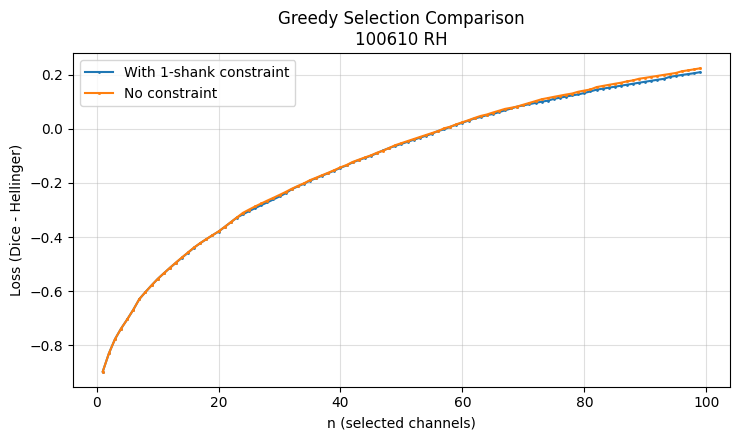

In [41]:
# -----------------
# Run Greedy: with and without 1-shank constraint
# -----------------

def greedy_selection(K_list, with_shank_constraint=True):
    results = {"dice": [], "H": [], "loss": [], "time": []}

    t2d = target_ds_pdf.reshape(h_ds, w_ds)
    bin_th_ds = np.percentile(t2d, DC_PERCENTILE)

    for K in K_list:
        t0 = time.time()
        remaining = set(range(n_ch))
        selected_local = []
        current_ds_raw = np.zeros((F_ds,), dtype=np.float32)
        used_shanks = set()

        for step in range(1, K+1):
            best_score, best_i = -1e9, None
            any_feasible = False

            for i in list(remaining):
                if with_shank_constraint and (shank_ids[i] in used_shanks):
                    continue
                any_feasible = True

                cand_ds_raw = current_ds_raw + X_ds[:, i]
                cand_ds_pdf = normalize_pdf(cand_ds_raw)

                c2d = cand_ds_pdf.reshape(h_ds, w_ds)
                dice_ds, _, _ = DC(t2d, c2d, bin_th_ds)
                H_ds = float(hellinger_distance(cand_ds_pdf, target_ds_pdf))
                loss_ds = float(dice_ds) - H_ds

                if loss_ds > best_score:
                    best_score, best_i = loss_ds, i

            if not any_feasible or best_i is None:
                break

            selected_local.append(best_i)
            remaining.remove(best_i)
            current_ds_raw += X_ds[:, best_i]

            if with_shank_constraint:
                used_shanks.add(shank_ids[best_i])

        sel_G = candidate_idx[np.array(selected_local, dtype=int)]

        # Full-res evaluation
        selected_pm_raw = np.zeros_like(target_pm_raw)
        for ch in sel_G:
            selected_pm_raw += get_raw_map(ch)
        selected_pdf = normalize_pdf(selected_pm_raw)

        d, h, loss_val = dice_H_loss(target_pdf, selected_pdf, BIN_THRESH)
        tG = time.time() - t0

        results["dice"].append(d)
        results["H"].append(h)
        results["loss"].append(loss_val)
        results["time"].append(tG)

    return results

# Run both conditions
print("Running with shank constraint...")
res_with = greedy_selection(K_list, with_shank_constraint=True)
print("Running without shank constraint...")
res_no = greedy_selection(K_list, with_shank_constraint=False)

# -----------------
# Plot comparison
# -----------------
plt.figure(figsize=(7.5, 4.5))
plt.plot(K_list[:len(res_with["loss"])], res_with["loss"], marker='o', label="With 1-shank constraint", markersize=1)
plt.plot(K_list[:len(res_no["loss"])], res_no["loss"], marker='s', label="No constraint", markersize=1)
plt.title(f"Greedy Selection Comparison\n{subject} {hemisphere}")
plt.xlabel("n (selected channels)")
plt.ylabel("Loss (Dice - Hellinger)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()
